In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


# 1. Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl

from catboost import Pool,CatBoostClassifier
from sklearn.metrics import roc_auc_score as AUC

# 2. EDA

#### Load dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
train

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


#### Load original dataset

In [4]:
original = pd.read_csv('/kaggle/input/machine-failure-predictions/machine failure.csv')
original

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


#### Drop irrelevant feature "id"

In [5]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
original.drop('UDI', axis=1, inplace=True)

#### Dataset info and describe

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 13.5+ MB


In [7]:
train.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualisation

train 98.42555468412141
original 96.61


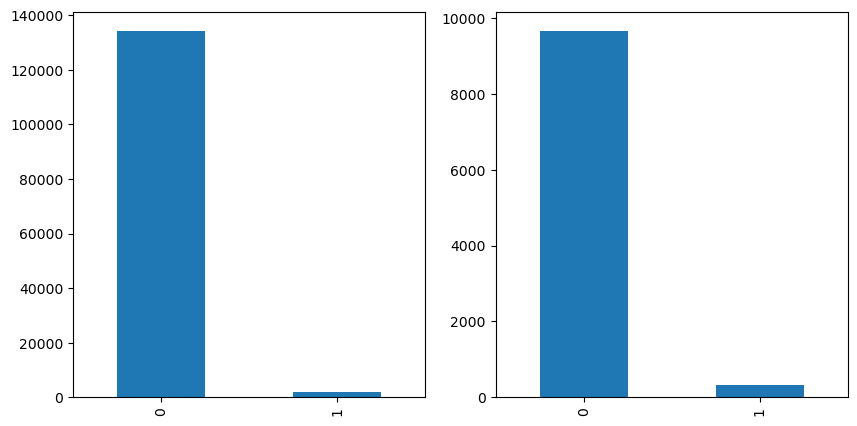

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

train['Machine failure'].value_counts().plot(kind='bar', ax=axes[0])
original['Machine failure'].value_counts().plot(kind='bar', ax=axes[1])

print('train', (len(train[train['Machine failure'] == 0]) / len(train)) * 100)
print('original', (len(original[original['Machine failure'] == 0]) / len(original)) * 100)

#### NOTE:
- We can see that the data is heavily distributed to 0
- 98% and 96%

## Correlation

<Axes: >

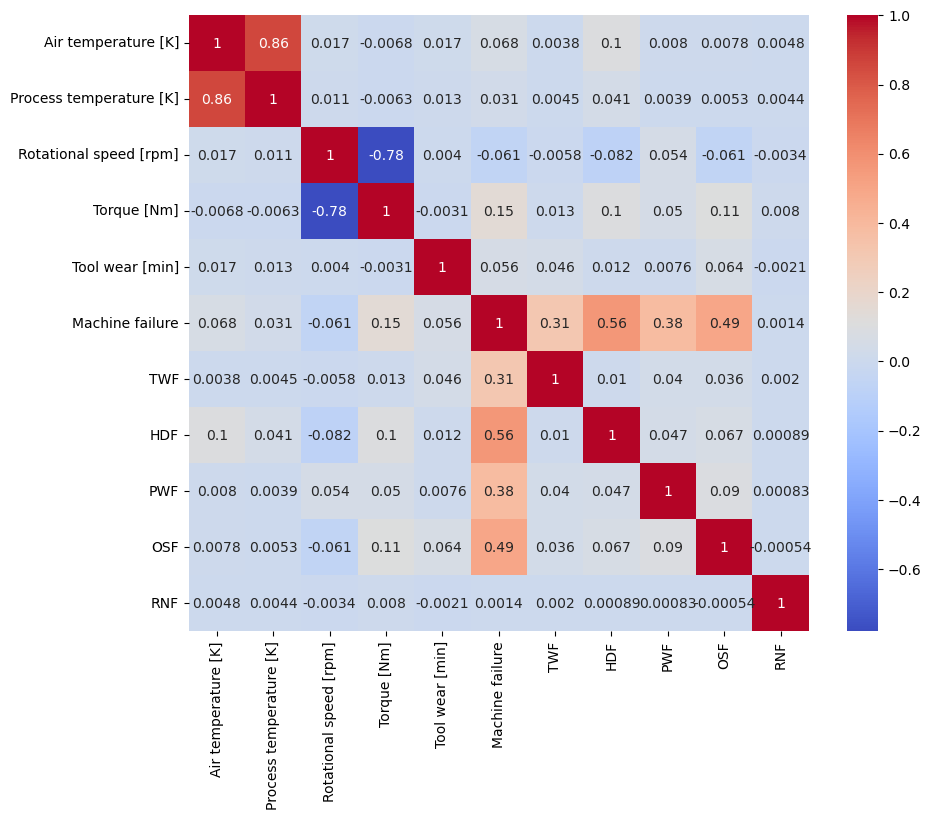

In [9]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Distribution of numerical variables grouped by Target

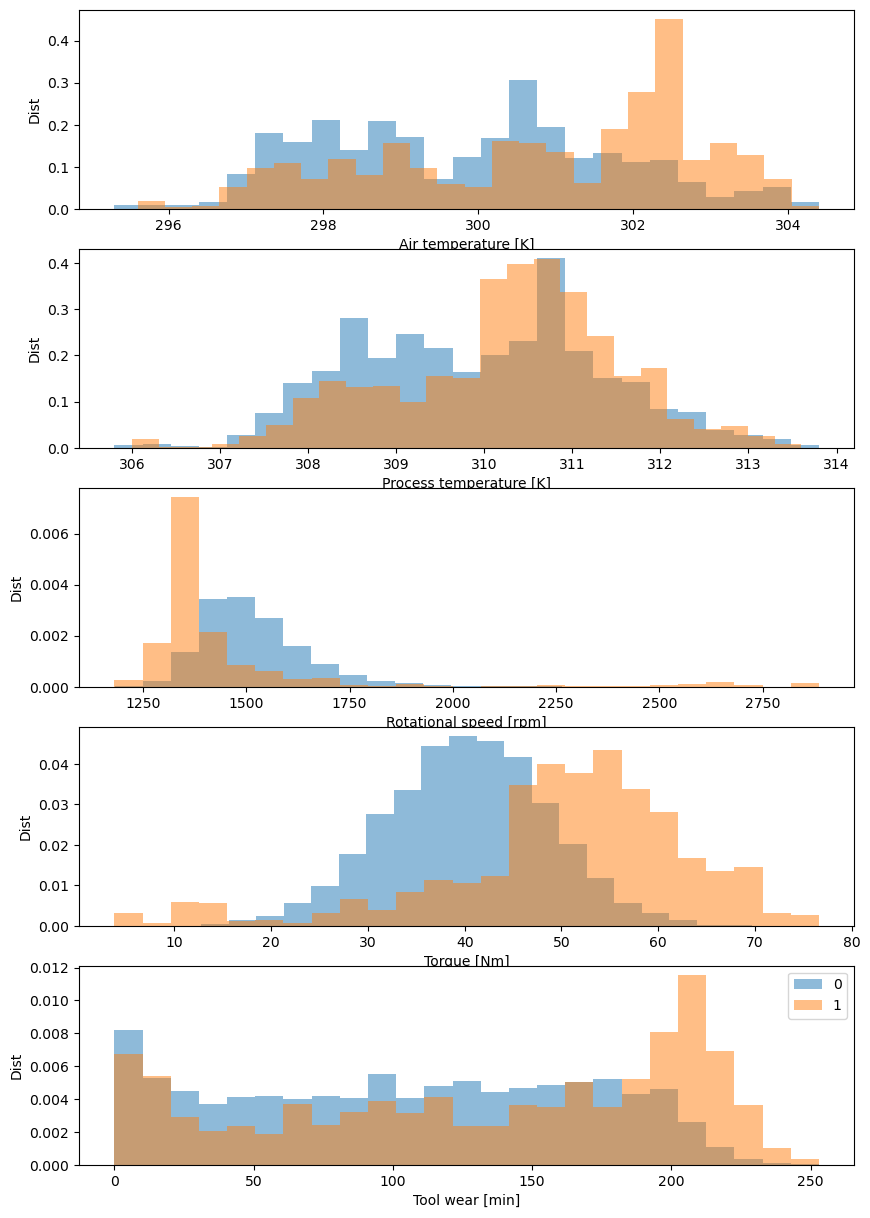

In [10]:
fig, axes = plt.subplots(5, 1, figsize=(10, 15))
axes = axes.flatten()

numerical_features = ['Air temperature [K]',
'Process temperature [K]',
'Rotational speed [rpm]',
'Torque [Nm]',
'Tool wear [min]']

failures = [0, 1]

i = 0
for feature in numerical_features:
    for failure in failures:
        subset = train[train['Machine failure'] == failure]
        axes[i].hist(subset[feature], alpha=0.5, label=failure, density=True, bins=25)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Dist')
        plt.legend()
    i += 1

plt.show()

## Categorical Features Visualisation

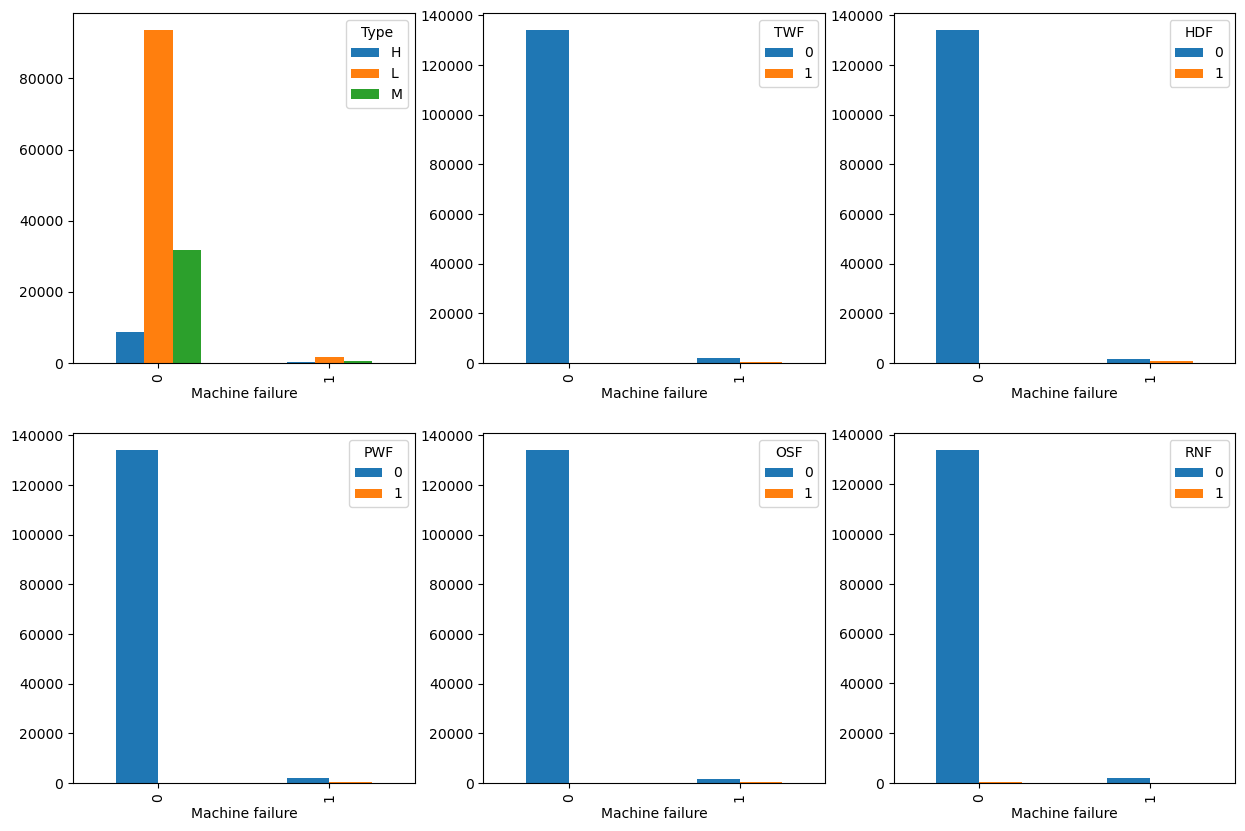

In [11]:
categorical_features = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

i = 0
for feature in categorical_features:
    train.groupby('Machine failure')[feature].value_counts().unstack().plot(kind='bar', ax=axes[i])
    i += 1

# 3. Models

In [12]:
joined_train_orig = pd.concat([train, original], axis = 0).reset_index(drop=True)
joined_train_orig

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146424,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
146425,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
146426,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
146427,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [13]:
y = joined_train_orig['Machine failure']
X = joined_train_orig.drop(columns=["Machine failure"])

In [14]:
feature_names = ['Product ID','Type',
                 'Air temperature [K]','Process temperature [K]',
                 'Rotational speed [rpm]','Torque [Nm]',
                 'Tool wear [min]','TWF','HDF',
                 'PWF','OSF','RNF']

train_pool = Pool(X.to_numpy(), y.to_numpy(), 
                  feature_names=feature_names, 
                  cat_features=['Product ID', 'Type'])

#### NOTE: the below params were obtained from another notebook (linked in reference). However, not specifying the params performed better.

In [15]:
# params ={'loss_function': 'Logloss',
#          'eval_metric': 'AUC',
#          'random_seed': 19970507,
#          'learning_rate': 0.027, 
#           'iterations': 927, 
#           'depth': 5, 
#           'subsample': 0.705}

# model = CatBoostClassifier(**params)

## Model using default hyperparameters

In [16]:
model = CatBoostClassifier() 

In [17]:
model.fit(train_pool, eval_set=train_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Train AUC score

In [18]:
train_auc = AUC(train["Machine failure"], model.predict(train.drop(columns=["Machine failure"])))
print(f"Train Score: {train_auc}")

Train Score: 0.9161043054090814


# 4. Submission

In [19]:
test_pool = Pool(test.to_numpy(), 
                 feature_names=feature_names, 
                 cat_features=['Product ID', 'Type'])
pred = model.predict_proba(test_pool)[:, 1]
pred

array([0.00106075, 0.00208216, 0.00034873, ..., 0.00051742, 0.00164063,
       0.00080096])

In [20]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')
sub['Machine failure'] = pred
sub.to_csv('submission.csv', index=False)

# 5. References
- https://www.kaggle.com/code/utisop/0-97718-catboost-machine-failure-prediction
- https://www.kaggle.com/code/collinsakal/machine-failure-baseline-submission-notebook